# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [128]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# todo
# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [129]:
# Track running time (including analysis)
start_time = time.time()

In [130]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [131]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [132]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [133]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [134]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [135]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [136]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [137]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [138]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [139]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [140]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [141]:
tf.keras.backend.clear_session()

## Run Setup

In [142]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
047A    28
057A    27
055A    20
097A    16
059A    14
111A    13
116A    12
051A    12
040A    10
014B    10
045A     9
094A     8
117A     7
050A     7
109A     6
108A     6
044A     5
104A     4
058A     3
056A     3
054A     2
093A     2
011A     2
061A     2
043A     1
049A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
046A    63
106A    14
042A    14
016A    10
051B     9
113A     3
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    147
F     64
M     25
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    77
M    33
F     3
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 047A, 109A, 050A, 043...
senior    [093A, 097A, 057A, 104A, 055A, 059A, 116A, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Unique Cat IDs per Age Group in Testing Set:
age_group
kitten                      [014B, 111A, 047A, 109A]
senior    [097A, 057A, 104A, 059A, 054A, 051A, 094A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 12, 'senior': 15}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 4, 'senior': 7}
Unique Training/Validation Group IDs:
['011A' '016A' '024A' '040A' '041A' '042A' '043A' '044A' '045A' '046A'
 '048A' '049A' '050A' '051B' '055A' '056A' '058A' '061A' '090A' '093A'
 '106A' '108A' '110A' '113A' '115A' '116A' '117A']
Unique Test Group IDs:
['014B' '047A' '051A' '054A' '057A' '059A' '094A' '097A' '104A' '109A'
 '111A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['011A' '016A' '024A' '040A' '041A' '042A' '043A' '044A' '045

Age group distribution: Counter({1: 164, 0: 146})
Epoch 1/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.4835 - accuracy: 0.7871
Epoch 2/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.2632 - accuracy: 0.9129
Epoch 3/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9226
Epoch 4/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1648 - accuracy: 0.9613
Epoch 5/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9548
Epoch 6/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1432 - accuracy: 0.9581
Epoch 7/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1523 - accuracy: 0.9516
Epoch 8/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.9645
Epoch 9/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.9484
Epoch 10/1500
10/10 [=============================


Before appending - Cat IDs: 203, Predictions: 203, Actuals: 203, Gender: 203
After appending - Cat IDs: 242, Predictions: 242, Actuals: 242, Gender: 242
Final Test Results - Loss: 0.6470031142234802, Accuracy: 0.7692307829856873, Precision: 0.7722222222222223, Recall: 0.71, F1 Score: 0.7225296442687748
Confusion Matrix:
 [[23  2]
 [ 7  7]]
outer_fold 4
Train Set Group Distribution:
046A    63
047A    28
057A    27
097A    16
042A    14
106A    14
059A    14
111A    13
051A    12
016A    10
014B    10
051B     9
045A     9
094A     8
050A     7
108A     6
109A     6
044A     5
104A     4
058A     3
113A     3
061A     2
011A     2
054A     2
041A     1
043A     1
115A     1
110A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
055A    20
116A    12
040A    10
117A     7
056A     3
093A     2
049A     1
048A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    207
M     58
F     27
Name: gender, dtype: int64
Testing Se

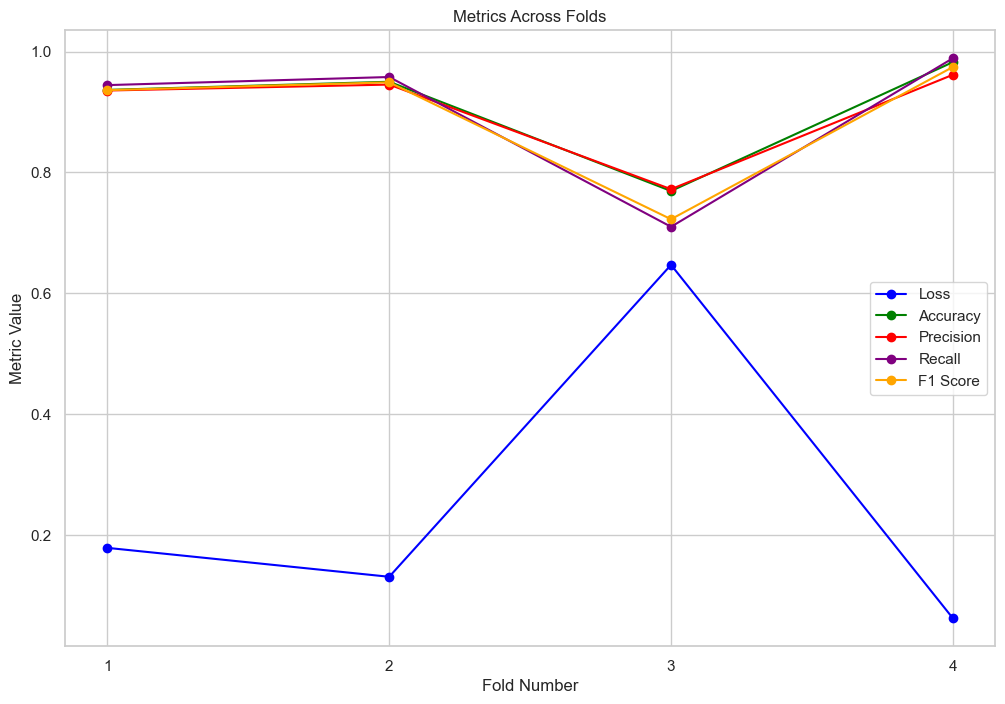

In [143]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [144]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 299, Predictions: 299, Actuals: 299, Gender: 299


In [145]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [146]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.89 (33/37)


In [147]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [148]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
17,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True
35,116A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
34,115A,[0],0,0.0,True
33,113A,"[1, 1, 1]",1,1.0,True
32,111A,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.0,True
31,110A,[0],0,0.0,True
30,109A,"[0, 0, 0, 0, 0, 0]",0,0.0,True
28,106A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]",1,1.0,True
27,104A,"[1, 1, 1, 1]",1,1.0,True


In [149]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    18
Name: Majority_Correct, dtype: int64


In [150]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count    accuracy
0               0.0           15             15  100.000000
1               1.0           22             18   81.818182


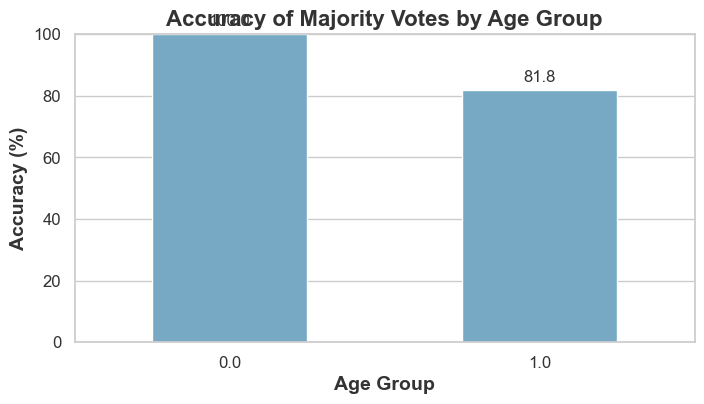

In [151]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [152]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843


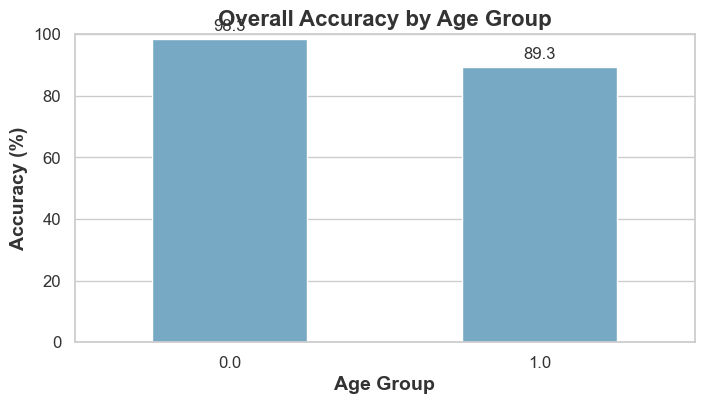

In [153]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [154]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52     89.66
2          X    174      165     94.83


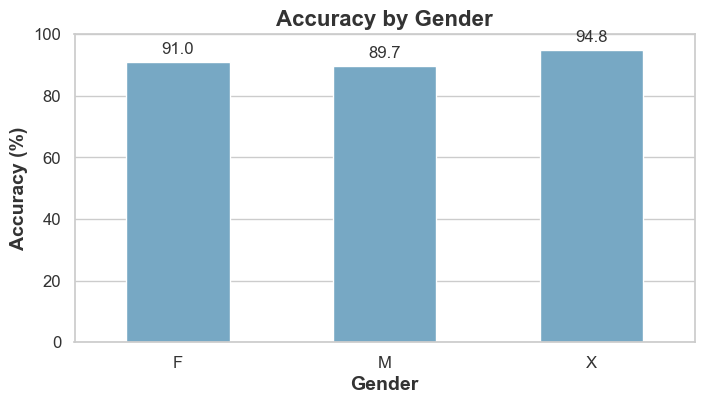

In [155]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [156]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.8918918918918919]
Total Class Statistics so far:
 [   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52     89.66
2          X    174      165     94.83]


# RANDOM SEED 2

In [157]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1])) 
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [158]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [159]:
tf.keras.backend.clear_session()

## Run Setup

In [160]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
057A    27
097A    16
106A    14
042A    14
059A    14
111A    13
116A    12
014B    10
040A    10
016A    10
045A     9
051B     9
094A     8
050A     7
117A     7
109A     6
108A     6
104A     4
056A     3
058A     3
113A     3
054A     2
061A     2
049A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
055A    20
051A    12
044A     5
093A     2
011A     2
043A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    216
M     58
F     33
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    34
X     8
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 111A, 040A, 046A, 047A, 042A, 109A, 050...
senior    [097A, 057A, 106A, 104A, 059A, 113A, 116A, 051...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_g

Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 42, Predictions: 42, Actuals: 42, Gender: 42
Final Test Results - Loss: 0.1516280174255371, Accuracy: 0.9285714030265808, Precision: 0.8333333333333333, Recall: 0.9583333333333333, F1 Score: 0.8782608695652174
Confusion Matrix:
 [[ 6  0]
 [ 3 33]]
outer_fold 2
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
106A    14
042A    14
051A    12
116A    12
040A    10
016A    10
014B    10
045A     9
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
058A     3
113A     3
093A     2
011A     2
043A     1
049A     1
041A     1
110A     1
090A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
097A    16
059A    14
111A    13
051B     9
094A     8
117A     7
054A     2
061A     2
048A     1
115A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    191
F     60
M     24
Name: gender, dtype: int64
Testing S

Train Age Group Distribution AFTER SWAP:
senior    124
kitten     99
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
kitten    72
senior    54
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({1: 124, 0: 99})
Epoch 1/1500
7/7 [==============================] - 0s 2ms/step - loss: 0.7476 - accuracy: 0.6861
Epoch 2/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.3537 - accuracy: 0.8565
Epoch 3/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.2837 - accuracy: 0.9013
Epoch 4/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.2582 - accuracy: 0.9013
Epoch 5/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.2039 - accuracy: 0.9238
Epoch 6/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.9327
Epoch 7/1500
7/7 [==============================] - 0s 1ms/step - loss: 0.1903 - accuracy: 0.9327
Epoch 8/1500
7/7 [=====

Majority Vote Accuracy for cat_id for this fold: 1.00 (12/12)
Before appending - Cat IDs: 116, Predictions: 116, Actuals: 116, Gender: 116
After appending - Cat IDs: 242, Predictions: 242, Actuals: 242, Gender: 242
Final Test Results - Loss: 0.22334328293800354, Accuracy: 0.9126983880996704, Precision: 0.9174397031539889, Recall: 0.9050925925925926, F1 Score: 0.9096891900697205
Confusion Matrix:
 [[69  3]
 [ 8 46]]
outer_fold 4
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
059A    14
106A    14
111A    13
051A    12
014B    10
016A    10
040A    10
045A     9
051B     9
094A     8
117A     7
050A     7
109A     6
044A     5
056A     3
011A     2
061A     2
054A     2
093A     2
048A     1
043A     1
115A     1
110A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
042A    14
116A    12
108A     6
104A     4
113A     3
058A     3
049A     1
041A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution B

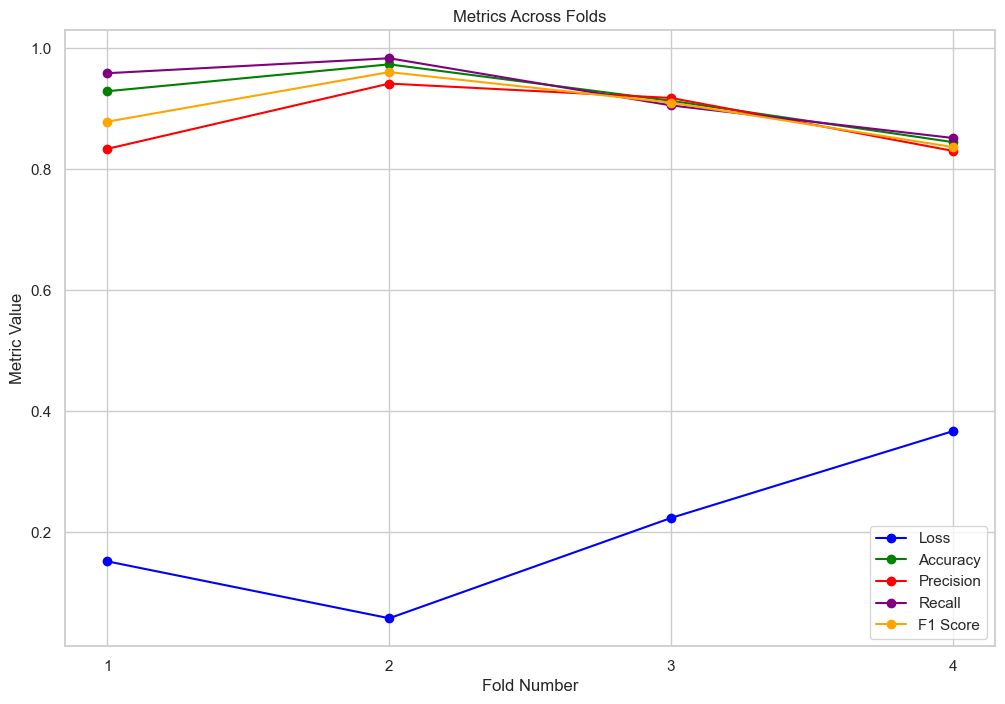

In [161]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [162]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 287, Predictions: 287, Actuals: 287, Gender: 287


In [163]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [164]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.86 (32/37)


In [165]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [166]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
17,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True
35,116A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
34,115A,[0],0,0.0,True
33,113A,"[1, 1, 1]",1,1.0,True
32,111A,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0.0,True
31,110A,[0],0,0.0,True
30,109A,"[1, 0, 0, 0, 1, 0]",0,0.0,True
28,106A,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]",1,1.0,True
27,104A,"[1, 1, 1, 1]",1,1.0,True


In [167]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    14
1.0    18
Name: Majority_Correct, dtype: int64


In [168]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           15             14  93.333333
1               1.0           22             18  81.818182


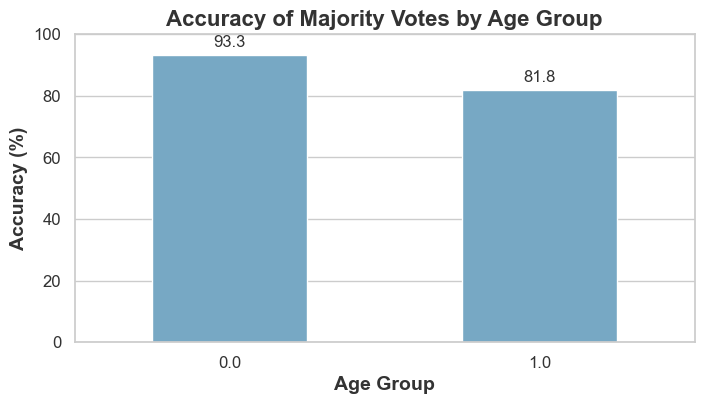

In [169]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [170]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          109            104  95.412844
1               1.0          178            160  89.887640


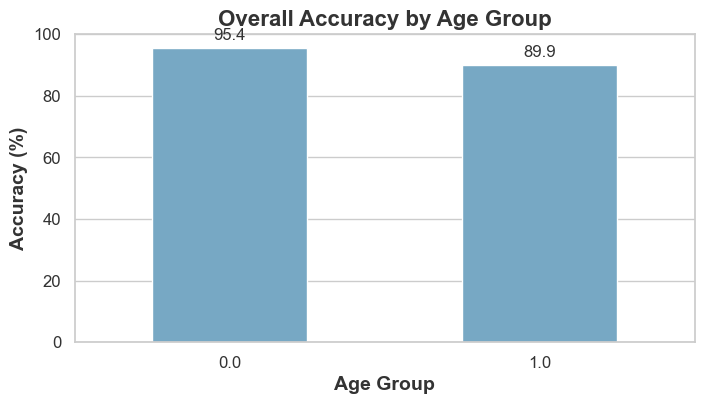

In [171]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [172]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       62     92.54
1          M     58       53     91.38
2          X    162      149     91.98


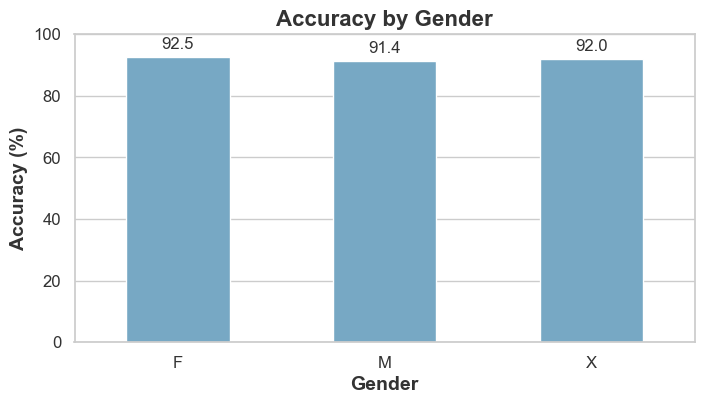

In [173]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [174]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.8918918918918919, 0.8648648648648649]
Total Class Statistics so far:
 [   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            104  95.412844
1               1.0          178            160  89.887640]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52     89.66
2          X    174      165     94.83,   all_gender  count  correct  accuracy
0          F     67       62     92.54
1          M     58       53     91.38
2          X    162      149     91.98]


# RANDOM SEED 3

In [175]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [176]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [177]:
tf.keras.backend.clear_session()

## Run Setup

In [178]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
116A    12
016A    10
040A    10
051B     9
045A     9
094A     8
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
058A     3
113A     3
011A     2
054A     2
093A     2
041A     1
049A     1
043A     1
048A     1
115A     1
090A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
057A    27
014B    10
117A     7
061A     2
110A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    186
F     60
M     55
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    38
F     7
M     3
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 111A, 040A, 046A, 047A, 042A, 109A, 050...
senior    [093A, 097A, 106A, 104A, 055A, 059A, 113A, 116...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Epoch 1/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.6431
Epoch 2/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7993
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3923 - accuracy: 0.8327
Epoch 4/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.3155 - accuracy: 0.8625
Epoch 5/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9182
Epoch 6/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9294
Epoch 7/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.9033
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2015 - accuracy: 0.9331
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.1820 - accuracy: 0.9554
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.1965 - accuracy: 0.9331
Epoch 11/1500
9/9 [

Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 040A, 046A, 047A, 042A, 050A, 043A, 041...
senior    [097A, 057A, 104A, 055A, 059A, 117A, 056A, 051...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
kitten                            [044A, 111A, 109A, 049A]
senior    [093A, 106A, 113A, 116A, 051B, 054A, 058A, 016A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 12, 'senior': 14}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 4, 'senior': 8}
Unique Training/Validation Group IDs:
['011A' '014B' '024A' '040A' '041A' '042A' '043A' '045A' '046A' '047A'
 '048A' '050A' '051A' '055A' '056A' '057A' '059A' '061A' '090A' '094A'
 '097A' '104A' '108A' '110A' '115A' '117A']
Unique Test Group IDs:
['016A' '044A' '049A' '051B' '054A' '058A' '093A' '106A' '109A' '111A'
 '113A' '116A']
No common groups found between train and test sets.
Moved to Training/Vali

Epoch 1/1500
9/9 [==============================] - 0s 2ms/step - loss: 0.7611 - accuracy: 0.6074
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.4065 - accuracy: 0.8630
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.8741
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2955 - accuracy: 0.8889
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.8963
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2451 - accuracy: 0.9148
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2464 - accuracy: 0.9222
Epoch 8/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.9556
Epoch 9/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.9370
Epoch 10/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.1911 - accuracy: 0.9519
Epoch 11/1500
9/9 [

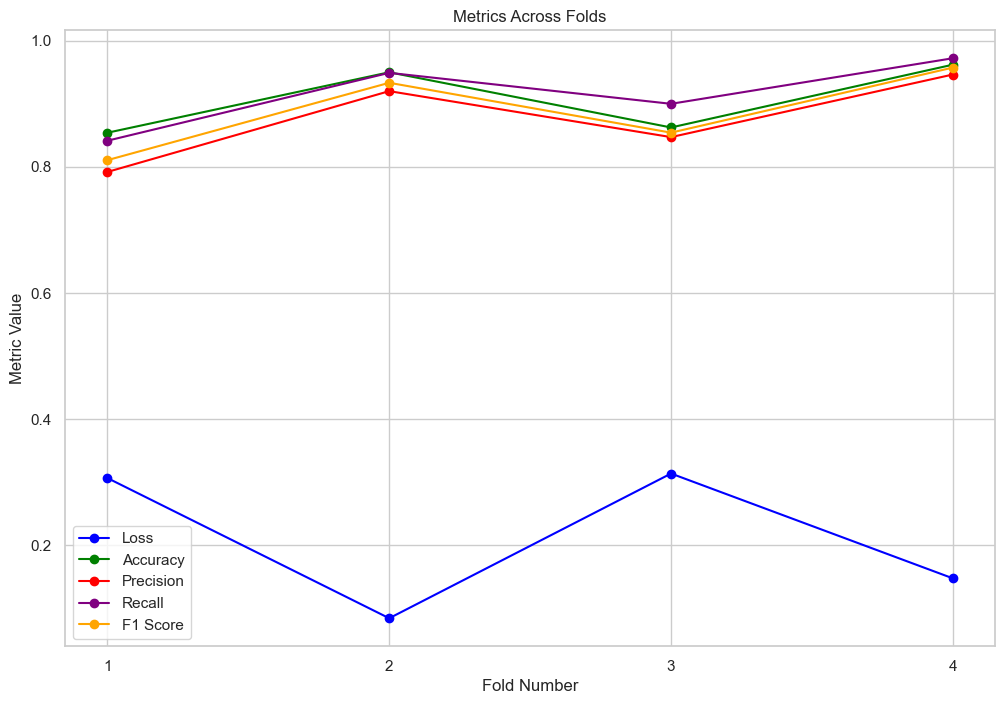

In [179]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [180]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 287, Predictions: 287, Actuals: 287, Gender: 287


In [181]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [182]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.92 (34/37)


In [183]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [184]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
27,104A,"[1, 1, 1, 1]",1,1.0,True
19,057A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",1,1.0,True
20,058A,"[1, 1, 1]",1,1.0,True
21,059A,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
23,090A,[1],1,1.0,True
25,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
26,097A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
29,108A,"[1, 1, 1, 1, 1, 1]",1,1.0,True
17,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True


In [185]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    19
Name: Majority_Correct, dtype: int64


In [186]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count    accuracy
0               0.0           15             15  100.000000
1               1.0           22             19   86.363636


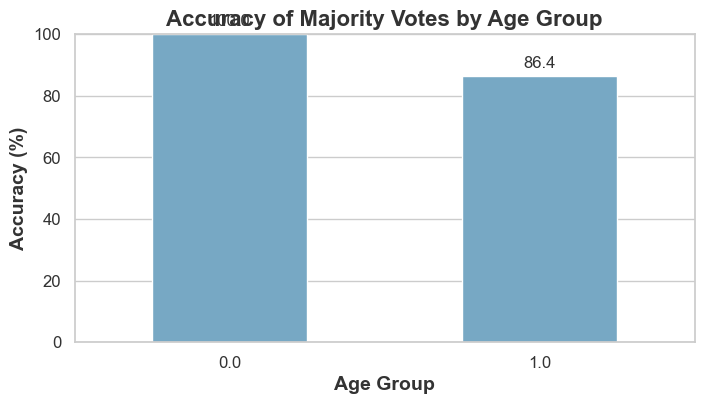

In [187]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [188]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          109            103  94.495413
1               1.0          178            159  89.325843


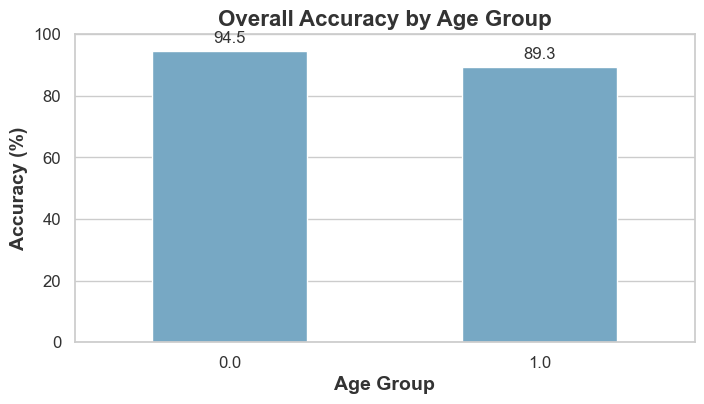

In [189]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [190]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       65     97.01
1          M     58       46     79.31
2          X    162      151     93.21


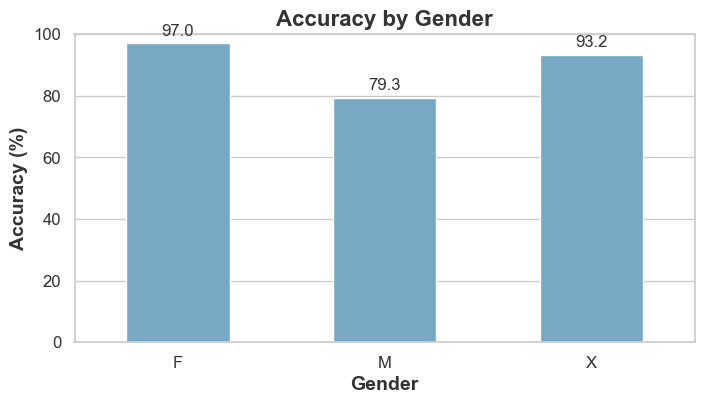

In [191]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [192]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.8918918918918919, 0.8648648648648649, 0.918918918918919]
Total Class Statistics so far:
 [   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            104  95.412844
1               1.0          178            160  89.887640,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            103  94.495413
1               1.0          178            159  89.325843]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52     89.66
2          X    174      165     94.83,   all_gender  count  correct  accuracy
0          F     67       62     92.54
1          M     58       53     91.38
2          X    162      149  

# RANDOM SEED 4

In [193]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [194]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [195]:
tf.keras.backend.clear_session()

## Run Setup

In [196]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1


Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
116A    12
051B     9
045A     9
094A     8
117A     7
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
113A     3
011A     2
061A     2
054A     2
093A     2
041A     1
048A     1
043A     1
115A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
014B    10
040A    10
016A    10
058A     3
049A     1
110A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    199
F     67
M     48
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    25
M    10
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 111A, 046A, 047A, 042A, 109A, 050A, 043...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 113...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
kitten 

Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 040A, 042A, 109A, 043A, 049A, 041A, 045...
senior    [093A, 097A, 057A, 106A, 104A, 059A, 113A, 116...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
kitten          [044A, 111A, 046A, 047A, 050A]
senior    [055A, 051B, 117A, 094A, 090A, 024A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 11, 'senior': 16}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 5, 'senior': 6}
Unique Training/Validation Group IDs:
['011A' '014B' '016A' '040A' '041A' '042A' '043A' '045A' '048A' '049A'
 '051A' '054A' '056A' '057A' '058A' '059A' '061A' '093A' '097A' '104A'
 '106A' '108A' '109A' '110A' '113A' '115A' '116A']
Unique Test Group IDs:
['024A' '044A' '046A' '047A' '050A' '051B' '055A' '090A' '094A' '111A'
 '117A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
{'046A'}
Rem

Unique Cat IDs per Age Group in Testing Set:
age_group
kitten                                   [043A, 045A, 048A]
senior    [097A, 057A, 106A, 104A, 059A, 113A, 116A, 056...
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 13, 'senior': 13}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 3, 'senior': 9}
Unique Training/Validation Group IDs:
['014B' '016A' '024A' '040A' '041A' '042A' '044A' '046A' '047A' '049A'
 '050A' '051A' '051B' '054A' '055A' '058A' '061A' '090A' '093A' '094A'
 '108A' '109A' '110A' '111A' '115A' '117A']
Unique Test Group IDs:
['011A' '043A' '045A' '048A' '056A' '057A' '059A' '097A' '104A' '106A'
 '113A' '116A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['014B' '016A' '024A' '040A' '041A' '042A' '044

Epoch 1/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.5107 - accuracy: 0.7723
Epoch 2/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.3131 - accuracy: 0.8845
Epoch 3/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.2587 - accuracy: 0.9208
Epoch 4/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.9340
Epoch 5/1500
10/10 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9373
Epoch 6/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9505
Epoch 7/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.9307
Epoch 8/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1907 - accuracy: 0.9340
Epoch 9/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1362 - accuracy: 0.9670
Epoch 10/1500
10/10 [==============================] - 0s 1ms/step - loss: 0.1172 - accuracy: 0.9769

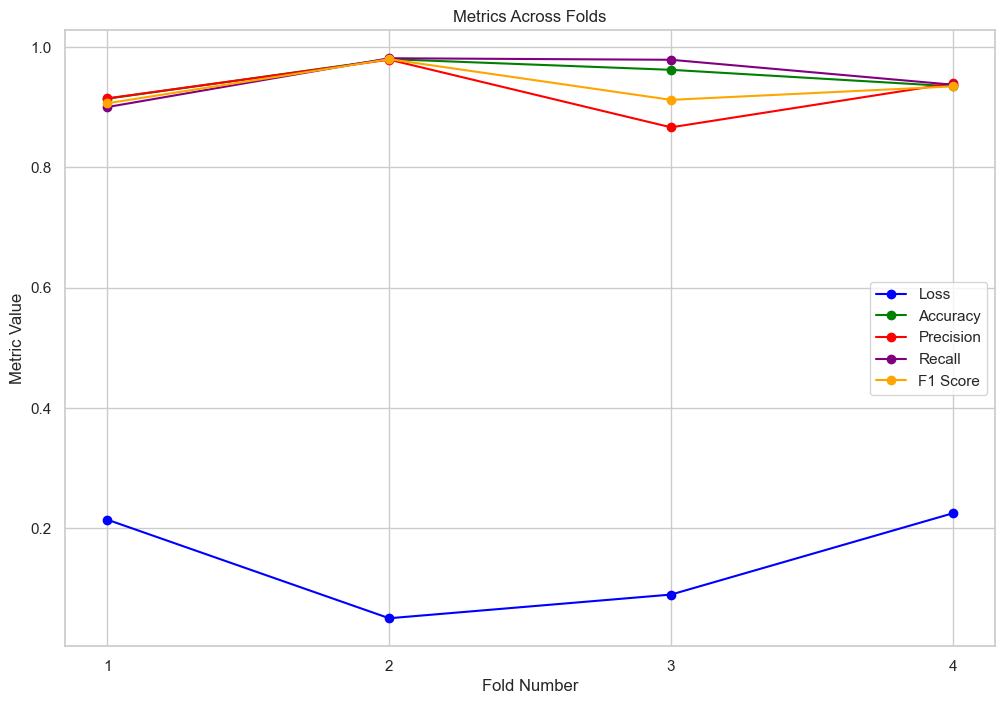

In [197]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [198]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 287, Predictions: 287, Actuals: 287, Gender: 287


In [199]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [200]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.97 (36/37)


In [201]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [202]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
1,014B,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0.0,True
20,058A,"[1, 1, 1]",1,1.0,True
21,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
22,061A,"[1, 1]",1,1.0,True
23,090A,[1],1,1.0,True
25,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
26,097A,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,104A,"[1, 1, 1, 1]",1,1.0,True
28,106A,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]",1,1.0,True


In [203]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    21
Name: Majority_Correct, dtype: int64


In [204]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count    accuracy
0               0.0           15             15  100.000000
1               1.0           22             21   95.454545


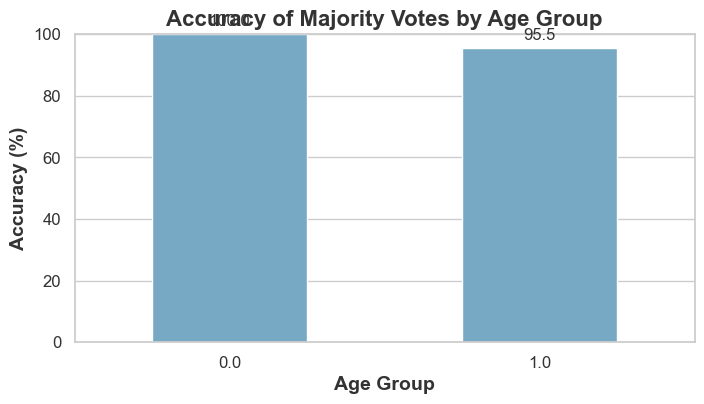

In [205]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [206]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          109            106  97.247706
1               1.0          178            169  94.943820


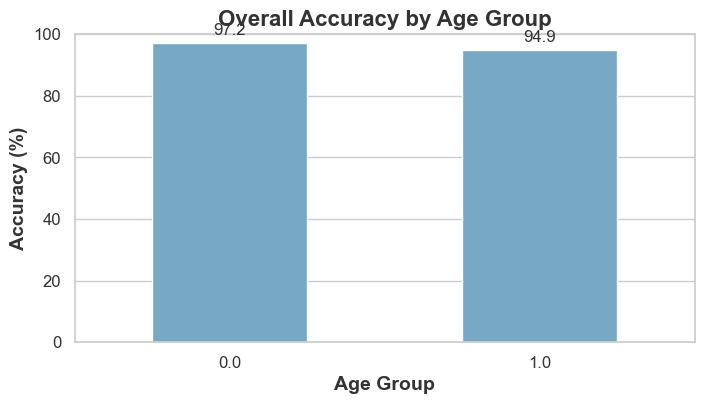

In [207]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [208]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       65     97.01
1          M     58       53     91.38
2          X    162      157     96.91


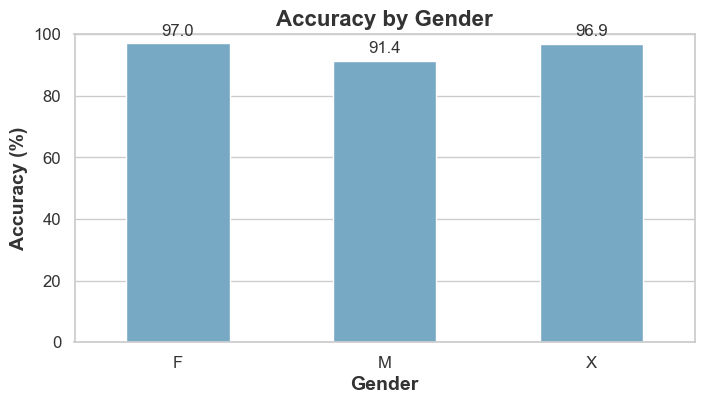

In [209]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [210]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.8918918918918919, 0.8648648648648649, 0.918918918918919, 0.972972972972973]
Total Class Statistics so far:
 [   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            104  95.412844
1               1.0          178            160  89.887640,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            103  94.495413
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            106  97.247706
1               1.0          178            169  94.943820]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52 

# RANDOM SEED 5

In [211]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [212]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [213]:
tf.keras.backend.clear_session()

## Run Setup

In [214]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)

outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
016A    10
040A    10
014B    10
045A     9
094A     8
117A     7
050A     7
109A     6
044A     5
104A     4
056A     3
054A     2
093A     2
011A     2
061A     2
043A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
116A    12
051B     9
108A     6
113A     3
058A     3
049A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    220
M     49
F     46
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    21
M     9
X     4
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 046A, 047A, 042A, 109...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Train Age Group Distribution AFTER SWAP:
kitten    152
senior    111
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
senior    67
kitten    19
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 152, 1: 111})
Epoch 1/1500
9/9 [==============================] - 1s 1ms/step - loss: 0.6817 - accuracy: 0.6350
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3800 - accuracy: 0.8631
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3098 - accuracy: 0.8859
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2367 - accuracy: 0.9202
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2807 - accuracy: 0.8973
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2414 - accuracy: 0.9240
Epoch 7/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.9506
Epoch 8/1500
9/9 [====

Unique Cat IDs per Age Group in Testing Set:
age_group
kitten    [046A, 042A, 043A, 041A, 045A, 048A]
senior    [097A, 055A, 059A, 056A, 011A, 024A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 10, 'senior': 16}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 6, 'senior': 6}
Unique Training/Validation Group IDs:
['014B' '016A' '040A' '044A' '047A' '049A' '050A' '051A' '051B' '054A'
 '057A' '058A' '061A' '090A' '093A' '094A' '104A' '106A' '108A' '109A'
 '110A' '111A' '113A' '115A' '116A' '117A']
Unique Test Group IDs:
['011A' '024A' '041A' '042A' '043A' '045A' '046A' '048A' '055A' '056A'
 '059A' '097A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
{'046A'}
Removed from Training/Validation Set:
{'040A'}
Moved to Test Set:
{'040A'}
Removed from Test Set
{'046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['014B' '016A' '044A' '046A' '047A' '049A' '050A' '051A' '051

Testing Set Age Group Distribution BEFORE SWAP:
kitten    62
senior    22
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
senior    156
kitten    109
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
kitten    62
senior    22
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({1: 156, 0: 109})
Epoch 1/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.6513 - accuracy: 0.6642
Epoch 2/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.4211 - accuracy: 0.8302
Epoch 3/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3207 - accuracy: 0.8943
Epoch 4/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.8981
Epoch 5/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.9057
Epoch 6/1500
9/9 [==============================] - 0s 1ms/step - loss: 0.2627 - accuracy: 0.9094
Epoch 7/1500
9/9

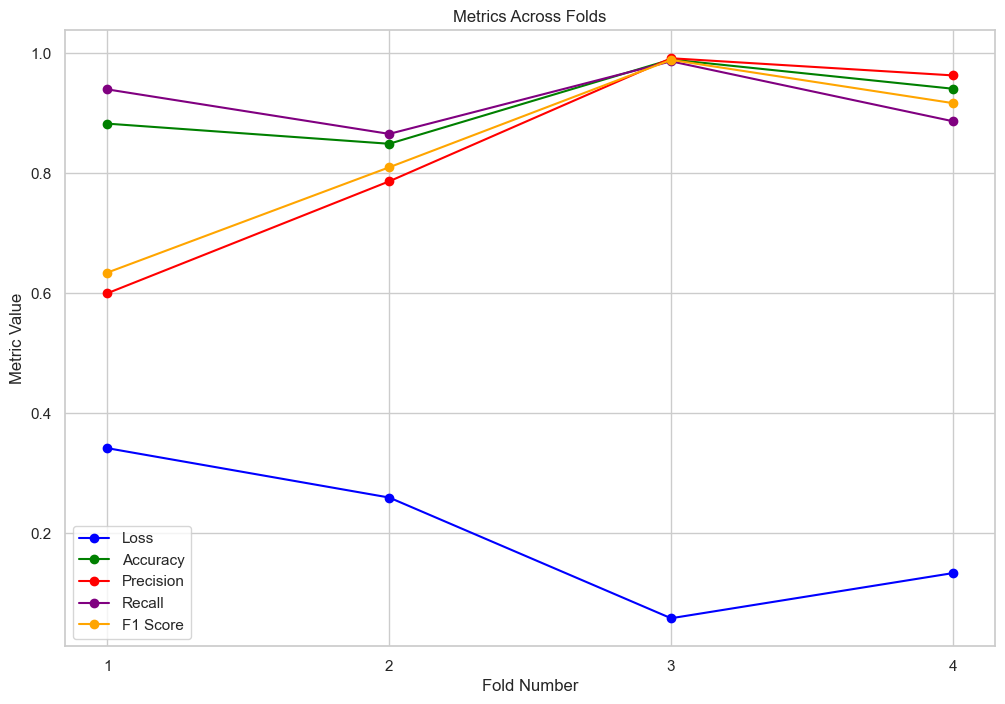

In [215]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [216]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 296, Predictions: 296, Actuals: 296, Gender: 296


In [217]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [218]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.92 (34/37)


In [219]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [220]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
28,106A,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]",1,1.0,True
19,057A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True
21,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
23,090A,[1],1,1.0,True
25,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
26,097A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,104A,"[1, 1, 1, 1]",1,1.0,True
29,108A,"[0, 1, 1, 1, 1, 0]",1,1.0,True
17,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True


In [221]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    19
Name: Majority_Correct, dtype: int64


In [222]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count    accuracy
0               0.0           15             15  100.000000
1               1.0           22             19   86.363636


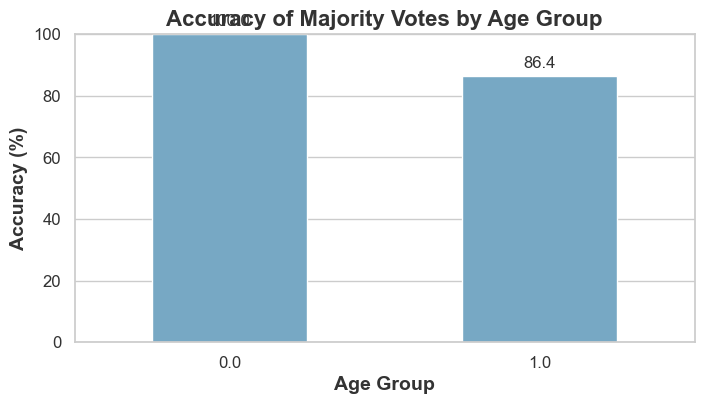

In [223]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [224]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          118            115  97.457627
1               1.0          178            158  88.764045


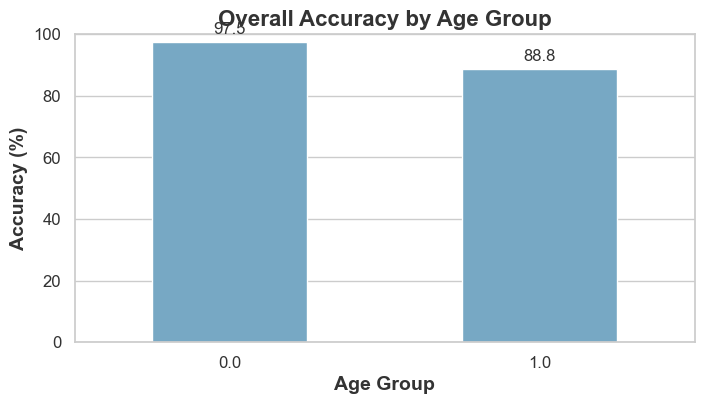

In [225]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [226]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       52     89.66
2          X    171      160     93.57


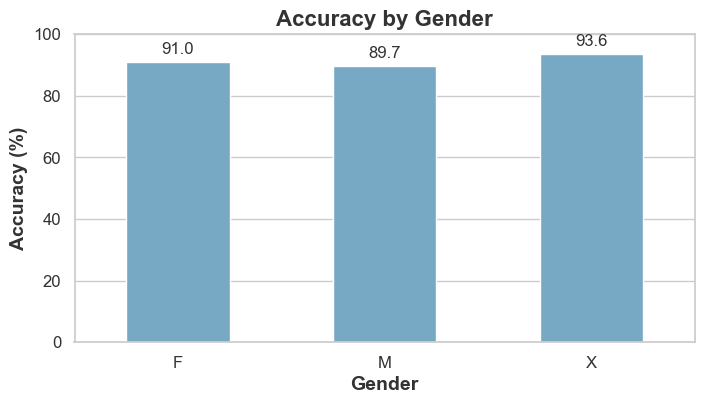

In [227]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [228]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.8918918918918919, 0.8648648648648649, 0.918918918918919, 0.972972972972973, 0.918918918918919]
Total Class Statistics so far:
 [   actual_age_group  total_count  correct_count   accuracy
0               0.0          121            119  98.347107
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            104  95.412844
1               1.0          178            160  89.887640,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            103  94.495413
1               1.0          178            159  89.325843,    actual_age_group  total_count  correct_count   accuracy
0               0.0          109            106  97.247706
1               1.0          178            169  94.943820,    actual_age_group  total_count  correct_count   accuracy
0               0.0          118            115  97.457627
1 

# --------------

# Total Final Results & Analysis

In [229]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
kitten    16
senior    22
Name: cat_id, dtype: int64


In [230]:
all_losses

[[0.1786857694387436,
  0.13084836304187775,
  0.6470031142234802,
  0.06222362816333771],
 [0.1516280174255371,
  0.05759727582335472,
  0.22334328293800354,
  0.3667675852775574],
 [0.3068283498287201,
  0.0845973938703537,
  0.3139762878417969,
  0.1478591412305832],
 [0.21449701488018036,
  0.05071006715297699,
  0.0900542214512825,
  0.22519835829734802],
 [0.3420588970184326,
  0.25985291600227356,
  0.0589001290500164,
  0.13406820595264435]]

In [231]:
all_accuracies

[[0.9365079402923584,
  0.949999988079071,
  0.7692307829856873,
  0.9824561476707458],
 [0.9285714030265808,
  0.9729729890823364,
  0.9126983880996704,
  0.8444444537162781],
 [0.8541666865348816,
  0.949999988079071,
  0.862500011920929,
  0.9620253443717957],
 [0.9142857193946838,
  0.9800000190734863,
  0.9622641801834106,
  0.9347826242446899],
 [0.8823529481887817,
  0.8488371968269348,
  0.989130437374115,
  0.9404761791229248]]

## Metrics

In [232]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 0.20233490094542503
Accuracy: 0.9188851714134216
Precision: 0.8841581810522776
Recall: 0.9218600100869259
F1 Score: 0.8902542060940384


## Majority Votes

In [233]:
# Average of majority vote accuracies
average_majority_vote_accuracy = np.mean(all_majority_vote_accuracies)
print("Average Majority Vote Accuracy:", average_majority_vote_accuracy)

Average Majority Vote Accuracy: 0.9135135135135137


In [234]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_majority_vote_details = pd.concat(all_majority_vote_details)
average_majority_vote_details = total_majority_vote_details.groupby('actual_age_group').agg({
    'total_count': 'sum', 
    'correct_count': 'sum' 
}).reset_index()
average_majority_vote_details['accuracy'] = (average_majority_vote_details['correct_count'] / average_majority_vote_details['total_count']) * 100

print("Average Class Statistics:")
print(average_majority_vote_details)

Average Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           75             74  98.666667
1               1.0          110             95  86.363636


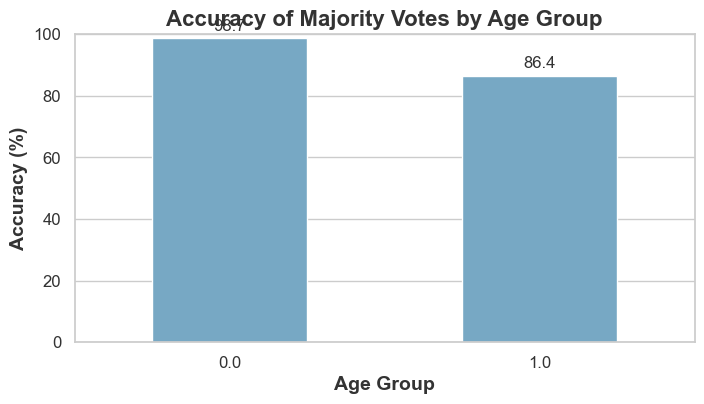

In [235]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(average_majority_vote_details, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [236]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_class_stats = pd.concat(all_class_stats)
average_class_stats = total_class_stats.groupby('actual_age_group').agg({
    'total_count': 'sum',  
    'correct_count': 'sum' 
}).reset_index()
average_class_stats['accuracy'] = (average_class_stats['correct_count'] / average_class_stats['total_count']) * 100

print("Average Class Statistics:")
print(average_class_stats)

Average Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          566            547  96.643110
1               1.0          890            805  90.449438


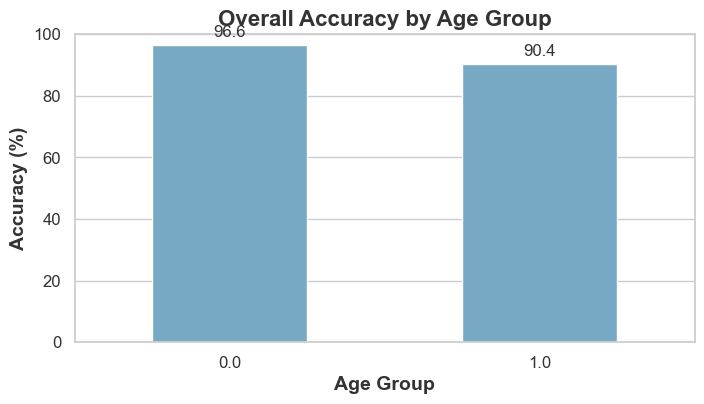

In [237]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(average_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

In [238]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F    335      314  93.731343
1          M    290      256  88.275862
2          X    831      782  94.103490


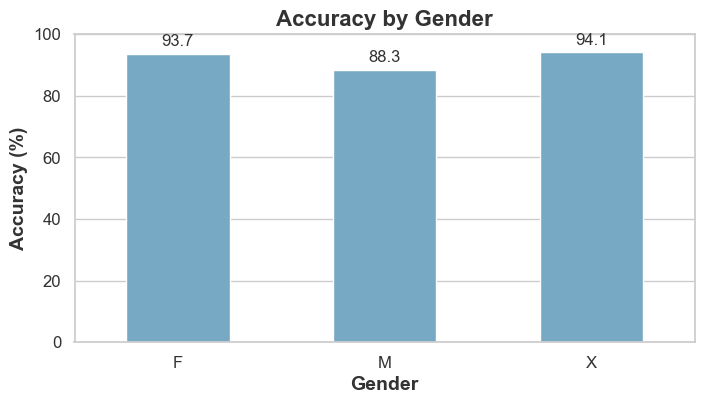

In [239]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

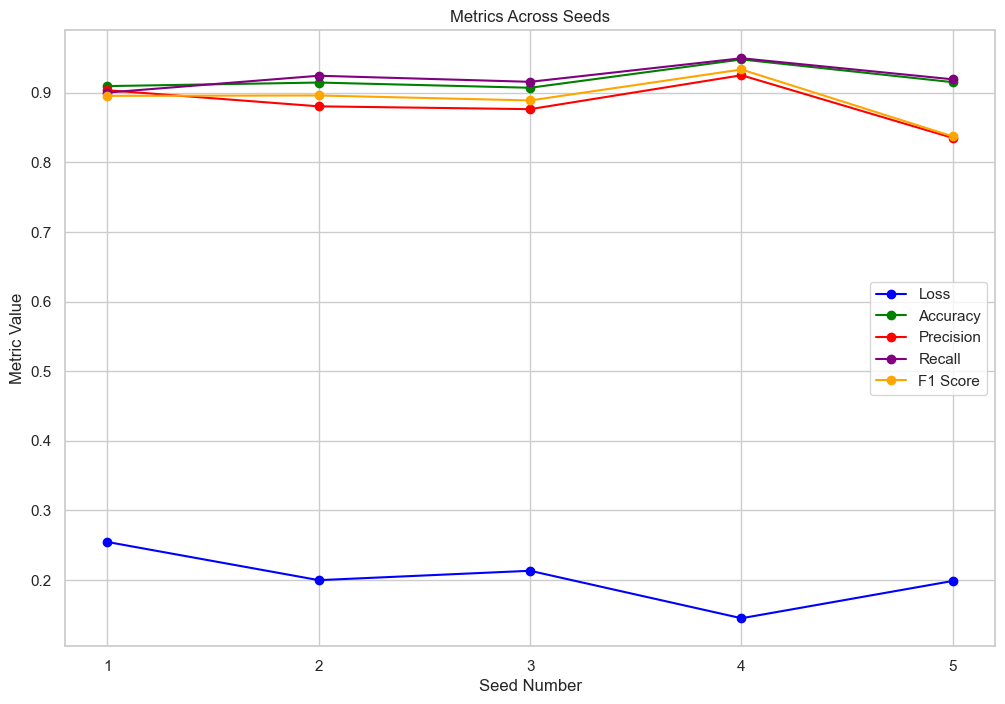

In [240]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1, "Seeds", "Seed Number")

## Display the seed folds results together

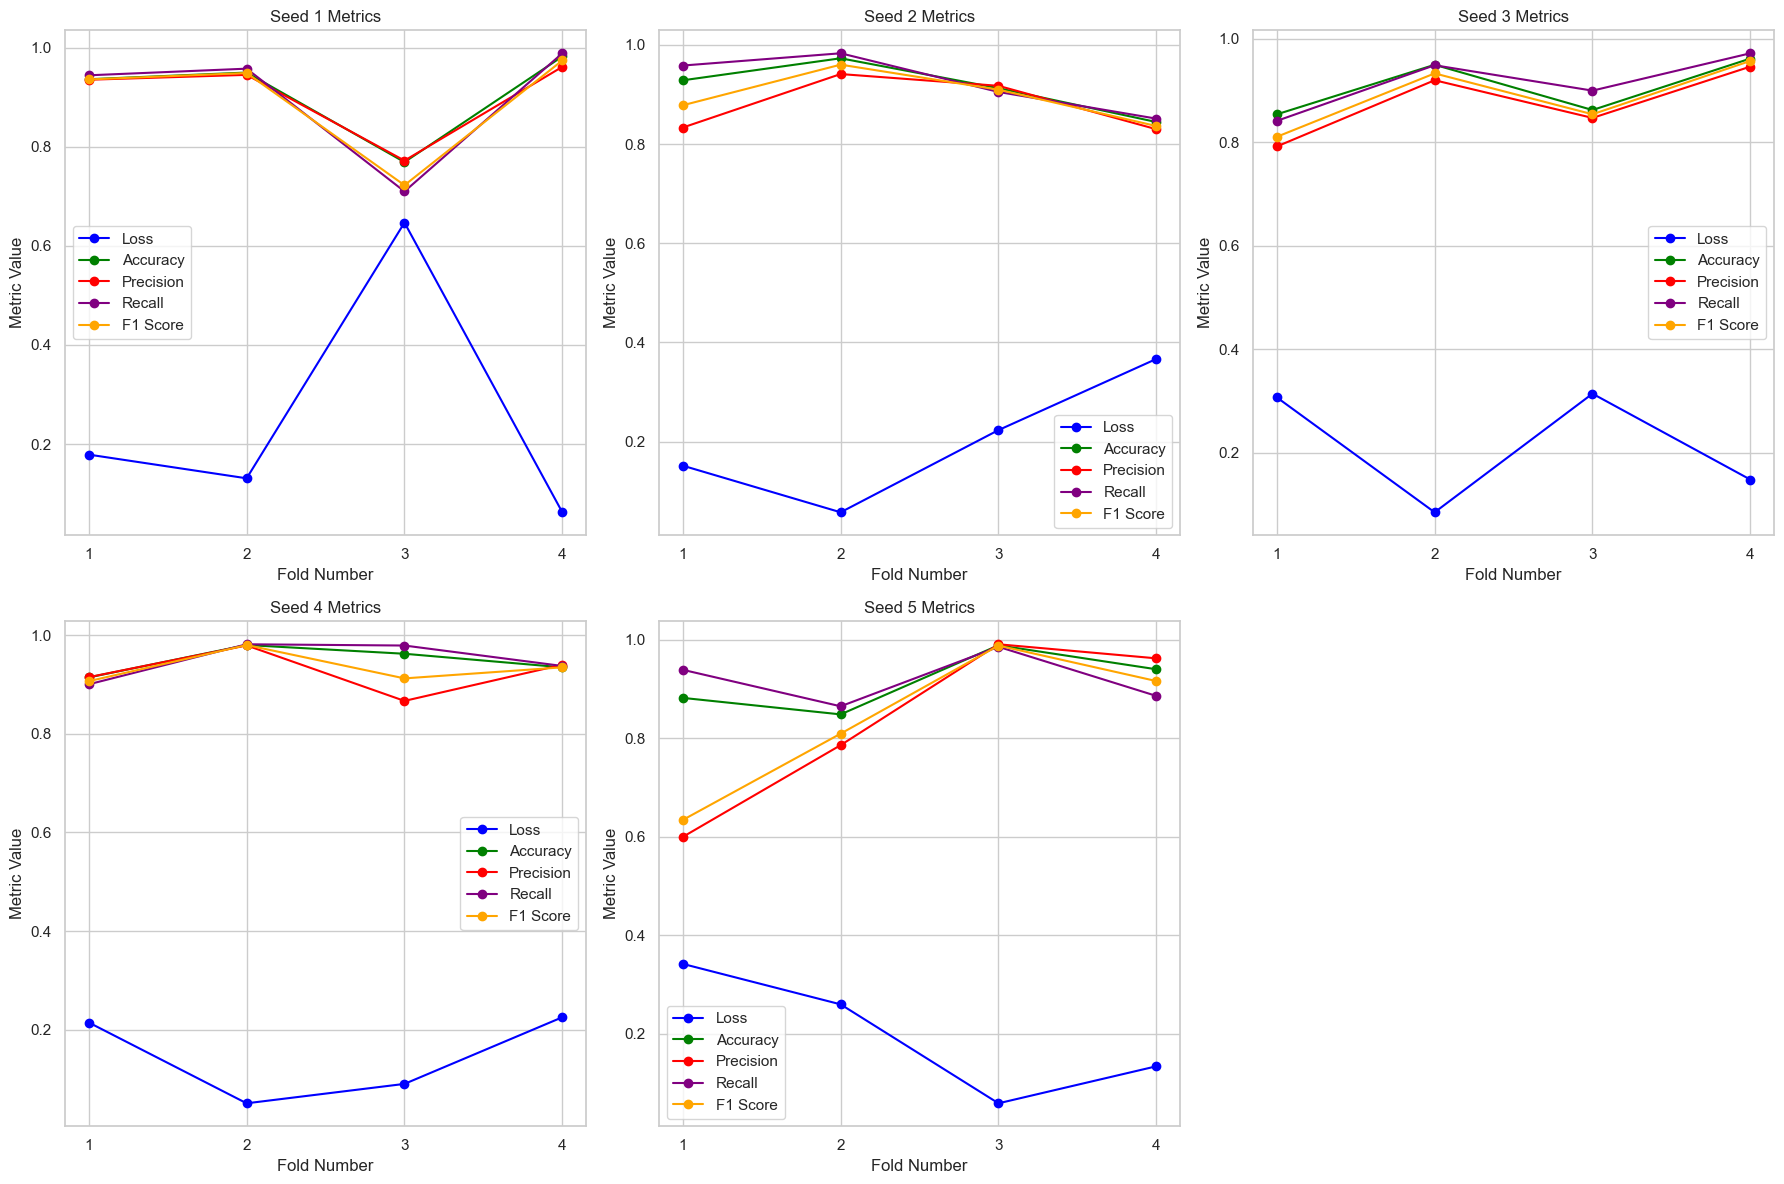

In [241]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

### Standard Deviation

In [242]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.14116928148655608
Accuracy: 0.05658839259385919
Precision: 0.09250256596133645
Recall: 0.06638709234877238
F1 Score: 0.08835673010175611


### Interquartile Range

In [243]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 0.1829067599028349
Accuracy: 0.08469533920288086
Precision: 0.11310163931463268
Recall: 0.07731259968102067
F1 Score: 0.10134815928759067


### Variation

In [244]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.019928766035430503
Accuracy: 0.003202246176356738
Precision: 0.0085567247094314
Recall: 0.004407246030524432
F1 Score: 0.007806911754274575


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [245]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.33, P-value: 0.853


#### Levene across seeds for ACCURACY

In [246]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.42, P-value: 0.789


#### Levene across seeds for PRECISION

In [247]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 2.35, P-value: 0.101


#### Levene across seeds for RECALL

In [248]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.32, P-value: 0.860


#### Levene across seeds for F1

In [249]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.27, P-value: 0.327


## Print out measurements for future further analysis (without rerunning notebook)

In [250]:
seed_1_folds_values

[[0.1786857694387436,
  0.13084836304187775,
  0.6470031142234802,
  0.06222362816333771],
 [0.9365079402923584,
  0.949999988079071,
  0.7692307829856873,
  0.9824561476707458],
 [0.935483870967742, 0.9453125, 0.7722222222222223, 0.9615384615384616],
 [0.9444444444444444, 0.9578313253012047, 0.71, 0.9888888888888889],
 [0.936105476673428,
  0.949061801548937,
  0.7225296442687748,
  0.9743820224719102]]

In [251]:
seed_2_folds_values

[[0.1516280174255371,
  0.05759727582335472,
  0.22334328293800354,
  0.3667675852775574],
 [0.9285714030265808,
  0.9729729890823364,
  0.9126983880996704,
  0.8444444537162781],
 [0.8333333333333333,
  0.9411764705882353,
  0.9174397031539889,
  0.8299595141700404],
 [0.9583333333333333,
  0.9830508474576272,
  0.9050925925925926,
  0.8512931034482758],
 [0.8782608695652174,
  0.9601293103448276,
  0.9096891900697205,
  0.8363636363636363]]

In [252]:
seed_3_folds_values

[[0.3068283498287201,
  0.0845973938703537,
  0.3139762878417969,
  0.1478591412305832],
 [0.8541666865348816,
  0.949999988079071,
  0.862500011920929,
  0.9620253443717957],
 [0.7920168067226891,
  0.9200968523002422,
  0.8472222222222222,
  0.9464285714285714],
 [0.8415233415233416, 0.9490940465918896, 0.9, 0.9722222222222222],
 [0.8107042253521127,
  0.9333333333333333,
  0.8542805100182149,
  0.9574123989218329]]

In [253]:
seed_4_folds_values

[[0.21449701488018036,
  0.05071006715297699,
  0.0900542214512825,
  0.22519835829734802],
 [0.9142857193946838,
  0.9800000190734863,
  0.9622641801834106,
  0.9347826242446899],
 [0.9148550724637681, 0.9791666666666667, 0.8666666666666667, 0.94],
 [0.9003496503496504, 0.9814814814814814, 0.9789473684210526, 0.9375],
 [0.9066666666666665,
  0.9799277398635087,
  0.91232423490488,
  0.9347517730496454]]

In [254]:
seed_5_folds_values

[[0.3420588970184326,
  0.25985291600227356,
  0.0589001290500164,
  0.13406820595264435],
 [0.8823529481887817,
  0.8488371968269348,
  0.989130437374115,
  0.9404761791229248],
 [0.6, 0.7863300492610837, 0.9912280701754386, 0.9626865671641791],
 [0.9393939393939394,
  0.8652788688138255,
  0.9861111111111112,
  0.8863636363636364],
 [0.6344086021505376,
  0.8097021276595744,
  0.9885329677178112,
  0.9165175909361956]]

## Training Accuracy Analysis

In [255]:
all_best_training_acc

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [256]:
total_training_acc

[[0.6398601531982422,
  0.8531468510627747,
  0.8916084170341492,
  0.8881118893623352,
  0.9265734553337097,
  0.9475524425506592,
  0.9335664510726929,
  0.9475524425506592,
  0.9370629191398621,
  0.9510489702224731,
  0.9510489702224731,
  0.9720279574394226,
  0.9790209531784058,
  0.9720279574394226,
  0.9825174808502197,
  0.9755244851112366,
  0.9685314893722534,
  0.9685314893722534,
  0.9650349617004395,
  0.9860140085220337,
  0.9825174808502197,
  0.9720279574394226,
  0.9895104765892029,
  0.9825174808502197,
  0.9895104765892029,
  0.9825174808502197,
  0.9895104765892029,
  0.9825174808502197,
  0.9790209531784058,
  0.9825174808502197,
  0.9930070042610168,
  0.9755244851112366,
  0.9895104765892029,
  0.9930070042610168,
  0.9790209531784058,
  0.9720279574394226,
  0.9860140085220337,
  0.9790209531784058,
  0.9930070042610168,
  0.9860140085220337,
  0.9895104765892029,
  0.9825174808502197,
  0.9895104765892029,
  0.996503472328186,
  0.9895104765892029,
  0.9895104

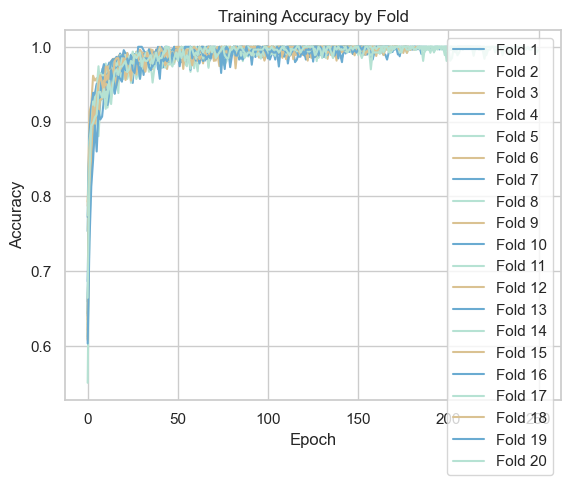

In [257]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [258]:
# todo
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 64.9246129989624 seconds
